In [104]:
from os.path import dirname, abspath, join
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

file = '2020-02-23-21-36-17.bag'
mpc_data_file = '/home/marcel/ros_ws/analytics_ws/src/performance_monitor/data/acceleration_data.csv'

dirPath = abspath(dirname(''))
image_file = join(join(join(dirname(dirPath), 'data'),'images'), file+'.png')
data_file = file+'.csv'

data_path = join(join(dirname(dirPath),'data'), data_file)

with open(data_path, 'r') as f:
    data_raw = pd.read_csv(f)

with open(mpc_data_file) as f:
    data_mpc = pd.read_csv(f)    

with open(join(join(dirname(dirPath),'data'), 'path.pkl'), 'rb') as f:
    path = pickle.load(f)

def moving_avg(poses, n):
    N = int(len(poses)/n)
    n = N
    moving_avg = []
    tmp = []
    for i in range(len(poses)):
        tmp.append(poses[i])
        if(i >= N):
            moving_avg.append(np.mean(tmp))
            tmp = []
            N = n+N
    return moving_avg

data_raw_200 = data_raw
path_200 = path
data_raw.head(5)

,t,speed,x_pos,y_pos,deviation,x_lin_acc,y_lin_acc,z_lin_acc
0,0.000026,0.0,-2.535677,-3.461602,0.239126,0.110132,0.610515,9.719163
1,0.000065,0.0,-2.535677,-3.461602,0.239126,0.110132,0.610515,9.719163
2,0.000094,0.0,-2.535677,-3.461602,0.239126,0.110132,0.610515,9.719163
3,0.000121,0.0,-2.535677,-3.461602,0.239126,0.110132,0.610515,9.719163
4,0.000150,0.0,-2.535677,-3.461602,0.239126,0.110132,0.610515,9.719163


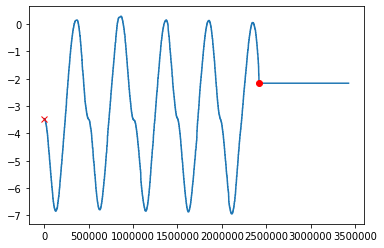

In [105]:
t = data_raw['t']
speed = data_raw['speed']
x_pos = data_raw['x_pos']
y_pos = data_raw['y_pos']

x_acc = data_raw['x_lin_acc']
y_acc = data_raw['y_lin_acc']
z_acc = data_raw['z_lin_acc']


# choose appropriate begining index and end index
plt.plot(y_pos)
ride_end_ind = 2420000
ride_start_ind = 2000
plt.plot(ride_end_ind, y_pos[ride_end_ind], 'or')
plt.plot(ride_start_ind, y_pos[ride_start_ind], 'xr')

# remove data, where car stands still
time_ = [ti for ti in t[ride_start_ind:ride_end_ind]]
speed_ = [s for s in speed[ride_start_ind:ride_end_ind]]
x_pos_ = [x for x in x_pos[ride_start_ind:ride_end_ind]]
y_pos_ = [y for y in y_pos[ride_start_ind:ride_end_ind]]

x_acc_ = [a for a in x_acc[ride_start_ind:ride_end_ind]]
y_acc_ = [a for a in y_acc[ride_start_ind:ride_end_ind]]
z_acc_ = [a for a in z_acc[ride_start_ind:ride_end_ind]]




path_x = [point['x'] for point in path]
path_y = [point['y'] for point in path]

In [106]:
# make an avarage
x_avg = moving_avg(x_pos_, 1000)
y_avg = moving_avg(y_pos_, 1000)

avg_x_acc = moving_avg(x_acc_, 1000)
avg_y_acc = moving_avg(y_acc_, 1000)
avg_z_acc = moving_avg(z_acc_, 1000)

speed_avg = moving_avg(speed_, 1000)

# Prędkość uśredniona podczas całego przejazdu

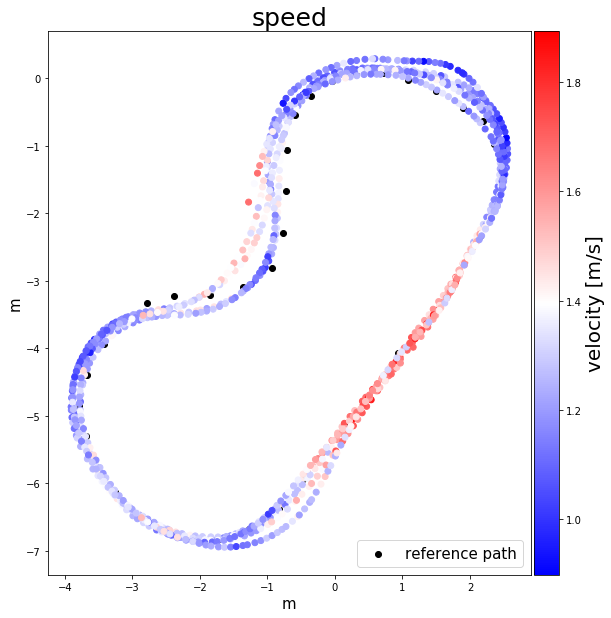

In [107]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca()
plt.title('speed', fontsize=25)
plt.xlabel('m', fontsize=15)
plt.ylabel('m', fontsize=15)
plt.scatter(path_x, path_y, color='black')
plt.legend(['reference path'], loc='lower right', fontsize=15)
im = plt.scatter(x_avg, y_avg, c=speed_avg, cmap='bwr')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cb = plt.colorbar(im, cax=cax)
cb.set_label('velocity [m/s]', fontsize=20)

ax.set_aspect('equal')
#ax.set_ylim(ymin=0)
#ax.set_xlim(xmin=0)
#plt.savefig(image_file)

# Extract turn after long straight

411759
411759
n_pathpoints_in_turn : 6


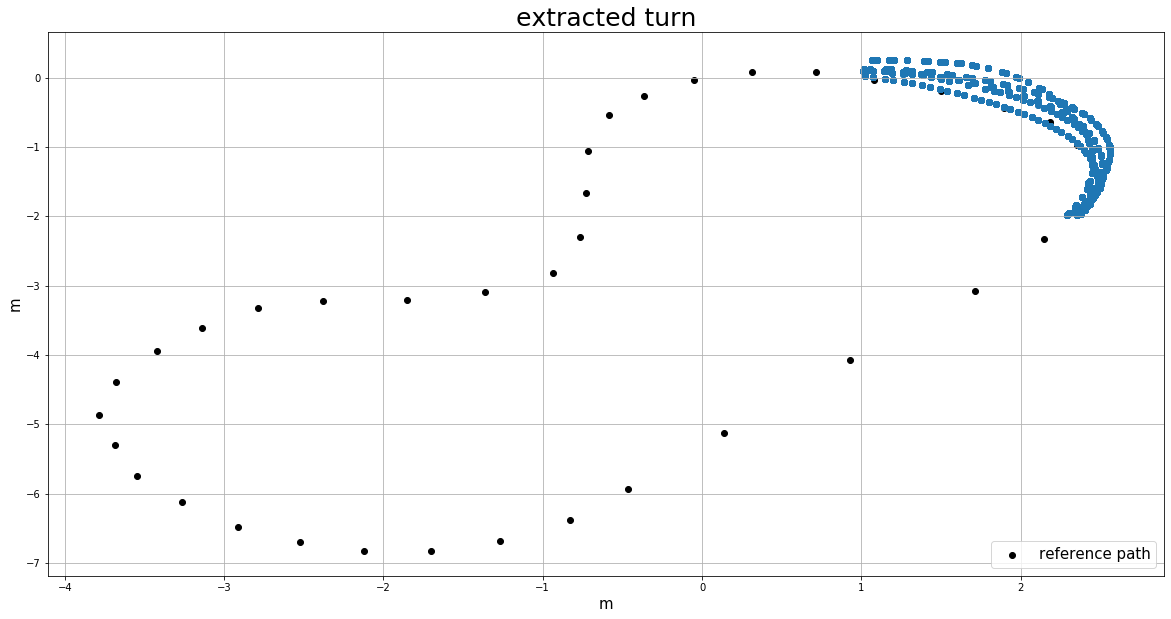

In [108]:
x_cut = 1
y_cut = -2

x_turn = []
y_turn = []
x_acc = []
y_acc = []
z_acc = []
global_idx = []

for i, x,y, xa, ya, za in zip(range(len(x_pos)),x_pos_, y_pos_, x_acc_, y_acc_, z_acc_):
    if(y>y_cut and x>x_cut):
        x_turn.append(x)
        y_turn.append(y)
        x_acc.append(xa)
        y_acc.append(ya)
        z_acc.append(za)
        global_idx.append(i)
print(len(x_turn))
print(len(x_acc))
  
x_acc_1_turn = x_acc
y_acc_1_turn = y_acc
    
n_pathpoints_in_turn = 0
for x,y in zip(path_x, path_y):
    if(y>y_cut and x>x_cut):
          n_pathpoints_in_turn=n_pathpoints_in_turn+1
print('n_pathpoints_in_turn : '+repr(n_pathpoints_in_turn))


fig = plt.figure(figsize=(20,10))
ax = plt.gca()
plt.title('extracted turn', fontsize=25)
plt.xlabel('m', fontsize=15)
plt.ylabel('m', fontsize=15)
plt.scatter(path_x, path_y, color='black')
plt.legend(['reference path'], loc='lower right', fontsize=15)
im = plt.scatter(x_turn, y_turn)
plt.grid(True)

## separate individual laps from each other

nr of turns: 4


Text(0.5, 1.0, 'lap 3 extracted on first turn')

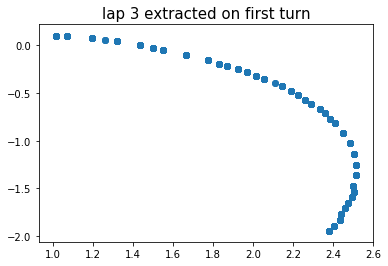

In [109]:

tmp = np.diff(x_turn)>np.max(np.diff(x_turn))/10
print('nr of turns: '+repr(sum(tmp)))
turn_end_indexes = np.argwhere(tmp)
turn_end_indexes = [int(t)+1 for t in turn_end_indexes]

global_end_turn_indexes = [global_idx[i] for i in turn_end_indexes]

turn_1_x = np.split(x_turn, turn_end_indexes)
turn_1_y = np.split(y_turn, turn_end_indexes)
turn_1_x_acc = np.split(x_acc, turn_end_indexes)
turn_1_y_acc = np.split(y_acc, turn_end_indexes)
turn_1_z_acc = np.split(z_acc, turn_end_indexes)

lap_nr = 3

#fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[10,5])
#ax1.plot(np.diff(x_turn))
#ax1.set_title('asc')
plt.scatter(turn_1_x[lap_nr], turn_1_y[lap_nr])
plt.title('lap '+ repr(lap_nr)+ ' extracted on first turn', fontsize=15)

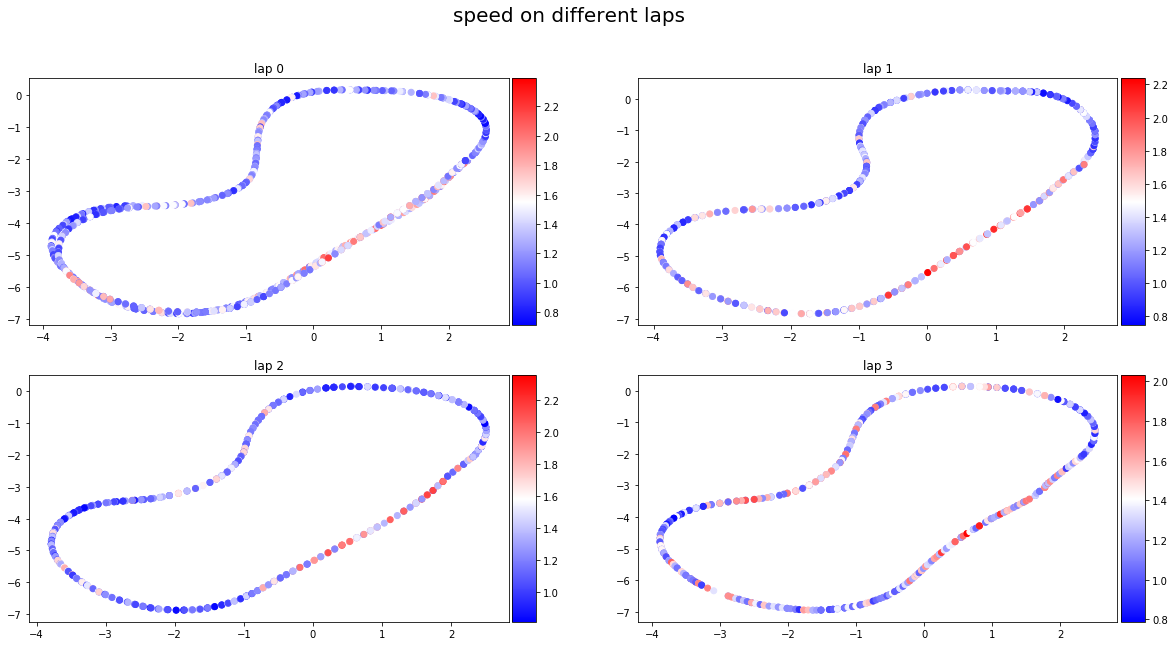

In [110]:
x_split = np.split(x_pos_, global_end_turn_indexes)
y_split = np.split(y_pos_, global_end_turn_indexes)
speed_split = np.split(speed_, global_end_turn_indexes)
x_acc_split = np.split(x_acc_, global_end_turn_indexes)
y_acc_split = np.split(y_acc_, global_end_turn_indexes)

r=1000

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[20,10])
axes = [ax1, ax2, ax3, ax4]
fig.suptitle('speed on different laps', fontsize=20)
for ax, i in zip(axes, range(4)):
   # ax.title('title', fontsize=25)
    #ax.scatter(path_x, path_y, color='black')
    im = ax.scatter(x_split[i][::r], y_split[i][::r], c=speed_split[i][::r], cmap='bwr')
    ax.set_title('lap '+repr(i))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    #cb.set_label('x acceleration [m/s]', fontsize=10)




# Histogramy przyspieszen dla pierwszego zakrętu

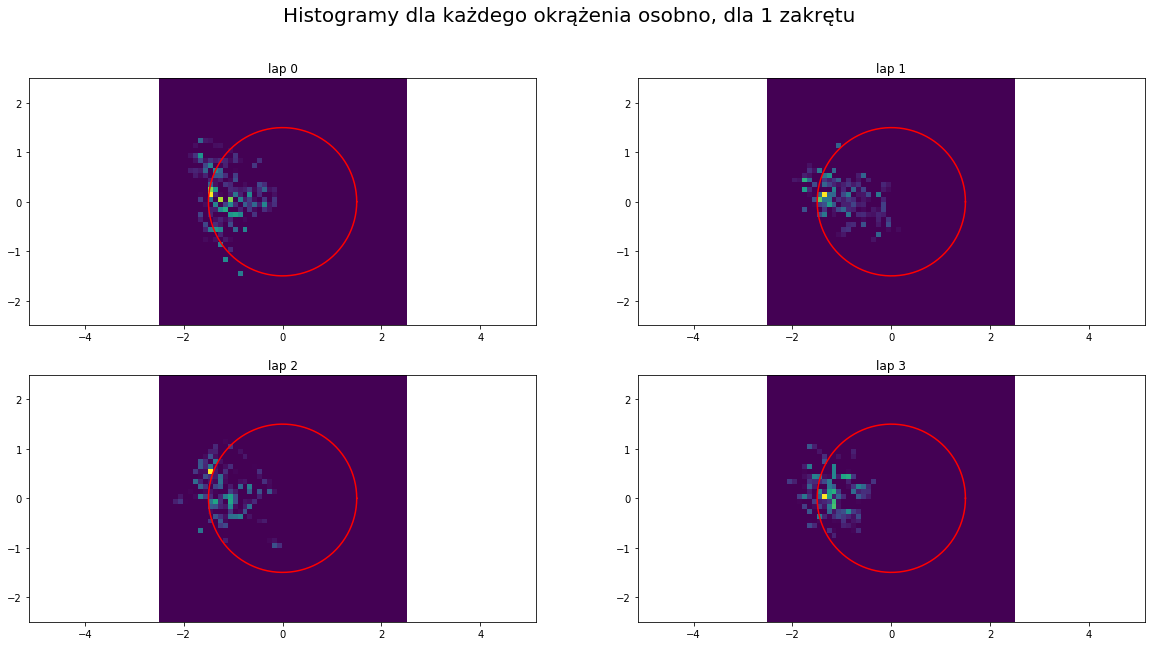

In [111]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[20,10])
axes = [ax1, ax2, ax3, ax4]
fig.suptitle('Histogramy dla każdego okrążenia osobno, dla 1 zakrętu', fontsize=20)
for ax, i in zip(axes, range(4)):
    ax.hist2d(turn_1_y_acc[i], turn_1_x_acc[i], bins=50, range=[[-2.5, 2.5], [-2.5, 2.5]])
    ax.set_title('lap '+repr(i))
    an = np.linspace(0, 2*np.pi, 100)
    ax.plot(1.5*np.cos(an), 1.5*np.sin(an), 'r')
    ax.axis('equal')


Text(0.5, 1.0, 'histogram dla wszystkich okrążeń na pierwszym zakręcie')

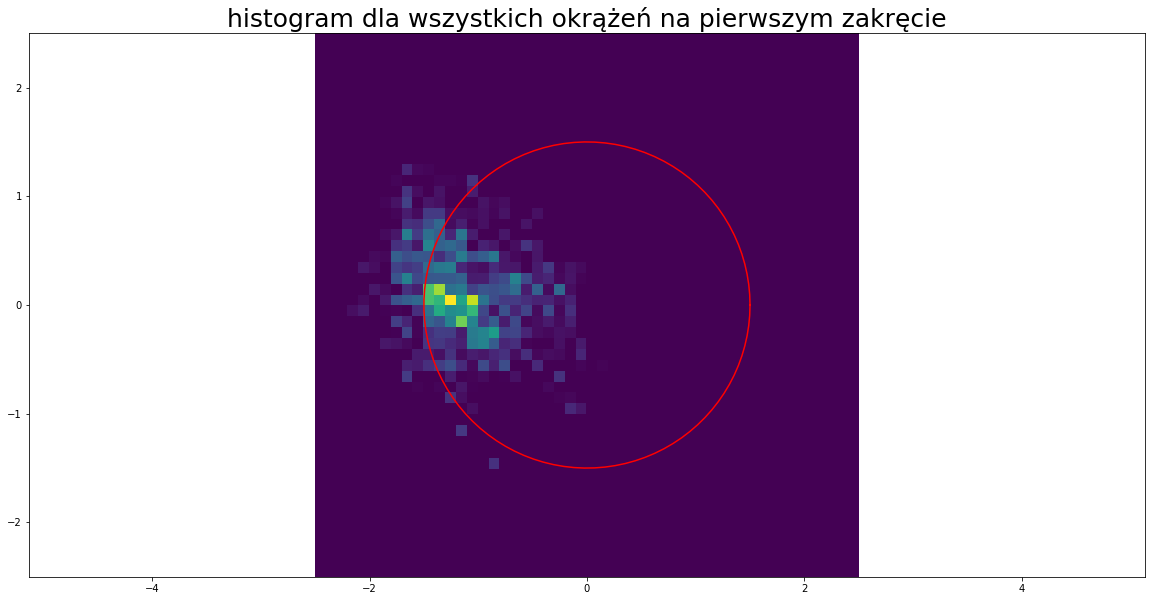

In [112]:
fig = plt.figure(figsize=(20,10))
plt.hist2d(y_acc, x_acc, bins=50, range=[[-2.5, 2.5], [-2.5, 2.5]])
plt.title('lap '+repr(i))
an = np.linspace(0, 2*np.pi, 100)
plt.plot(1.5*np.cos(an), 1.5*np.sin(an), 'r')
plt.axis('equal')
plt.title('histogram dla wszystkich okrążeń na pierwszym zakręcie', fontsize=25)

#   Ostatni zakręt przed prostą

435535
435535


Text(0.5, 1.0, 'extracted turn')

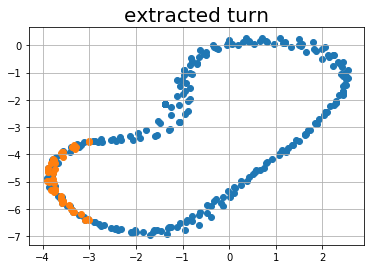

In [113]:
#punkt odcięcia zakrętu
x_cut = -3
y_cut = -3.5

x_turn = []
y_turn = []
x_acc = []
y_acc = []
z_acc = []
global_idx = []

for i, x,y, xa, ya, za in zip(range(len(x_pos)),x_pos, y_pos, x_acc_, y_acc_, z_acc_):
    if(y<y_cut and x<x_cut):
        x_turn.append(x)
        y_turn.append(y)
        x_acc.append(xa)
        y_acc.append(ya)
        z_acc.append(za)
        global_idx.append(i)
print(len(x_turn))
print(len(x_acc))


plt.scatter(x_pos[::10000], y_pos[::10000])
plt.scatter(x_turn[::10000], y_turn[::10000])
plt.grid(True)
plt.title('extracted turn', fontsize=20)

number of turns extracted: 4


(-3.9373543545318213,
 -2.952132023143817,
 -6.633194752007242,
 -3.3551324391592483)

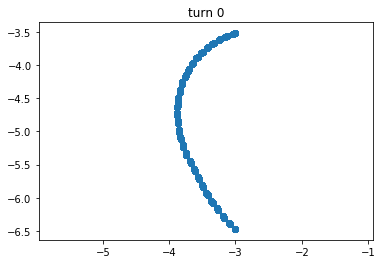

In [114]:
tmp = np.diff(y_turn)>np.max(np.diff(y_turn))/10
print('number of turns extracted: '+repr(sum(tmp)))

turn2_end_indexes = np.argwhere(tmp)
turn2_end_indexes = [int(t)+1 for t in turn2_end_indexes]
global_end_turn2_indexes = [global_idx[i] for i in turn2_end_indexes]

turn_2_x = np.split(x_turn, turn2_end_indexes)
turn_2_y = np.split(y_turn, turn2_end_indexes)
turn_2_x_acc = np.split(x_acc, turn2_end_indexes)
turn_2_y_acc = np.split(y_acc, turn2_end_indexes)
turn_2_z_acc = np.split(z_acc, turn2_end_indexes)

lap_nr = 0

plt.scatter(turn_2_x[lap_nr], turn_2_y[lap_nr])
plt.title('turn '+repr(lap_nr))
plt.axis('equal')

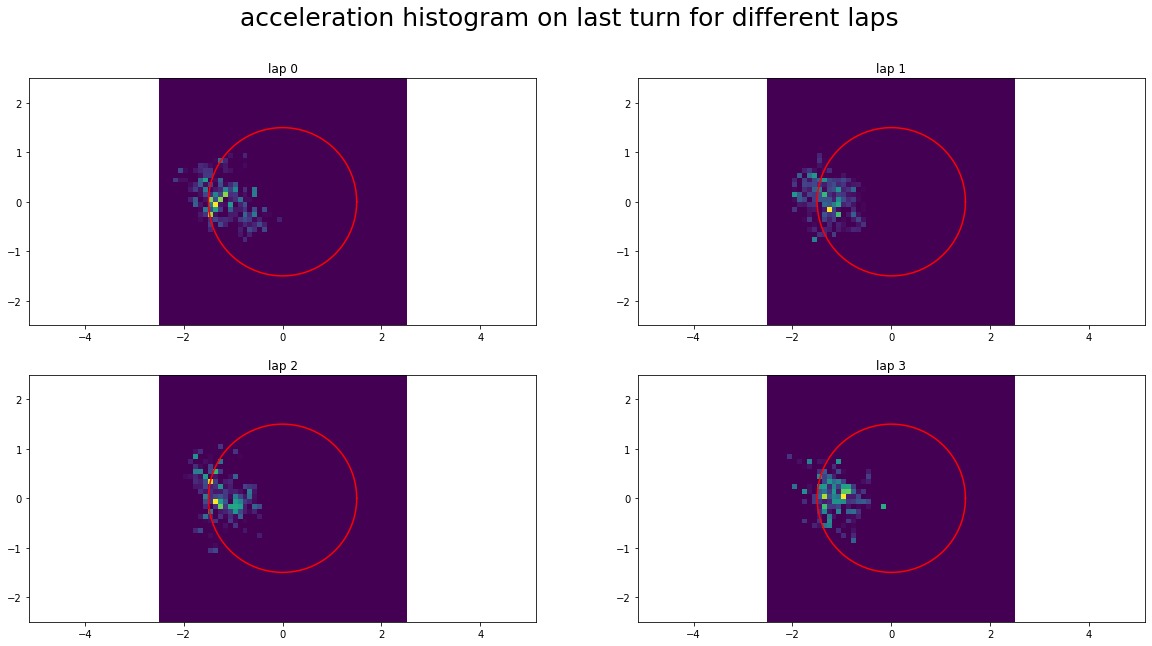

In [115]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[20,10])
axes = [ax1, ax2, ax3, ax4]
fig.suptitle('acceleration histogram on last turn for different laps', fontsize=25)
for ax, i in zip(axes, range(4)):
    ax.hist2d(turn_2_y_acc[i], turn_2_x_acc[i], bins=50, range=[[-2.5, 2.5], [-2.5, 2.5]])
    ax.set_title('lap '+repr(i))
    an = np.linspace(0, 2*np.pi, 100)
    ax.plot(1.5*np.cos(an), 1.5*np.sin(an), 'r')
    ax.axis('equal')


Text(0.5, 1.0, 'rozklad przyspieszen na pierwszym zakręcie')

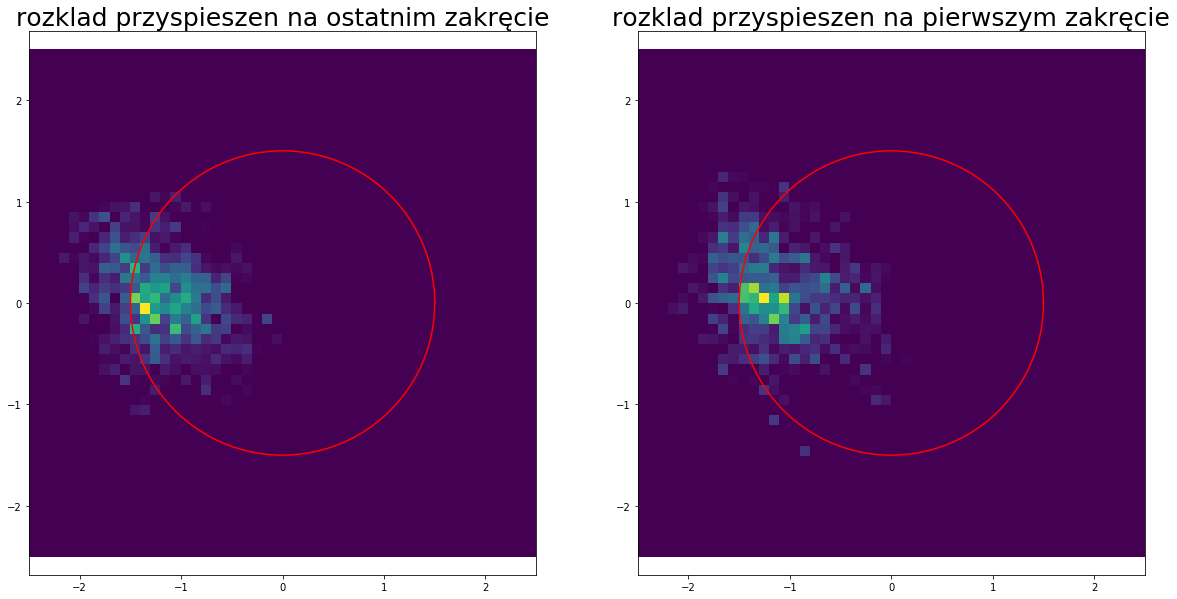

In [116]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[20,10])

ax1.hist2d(y_acc, x_acc, bins=50, range=[[-2.5, 2.5], [-2.5, 2.5]])
an = np.linspace(0, 2*np.pi, 100)
ax1.plot(1.5*np.cos(an), 1.5*np.sin(an), 'r')
ax1.axis('equal')
ax1.set_title('rozklad przyspieszen na ostatnim zakręcie', fontsize=25)
#ax1.savefig('21_33_left.jpg')

ax2.hist2d(y_acc_1_turn, x_acc_1_turn, bins=50, range=[[-2.5, 2.5], [-2.5, 2.5]])
ax2.plot(1.5*np.cos(an), 1.5*np.sin(an), 'r')
ax2.axis('equal')
ax2.set_title('rozklad przyspieszen na pierwszym zakręcie', fontsize=25)

Text(0.5, 1.0, 'rozklad przyspieszen podczas całego przejazdu')

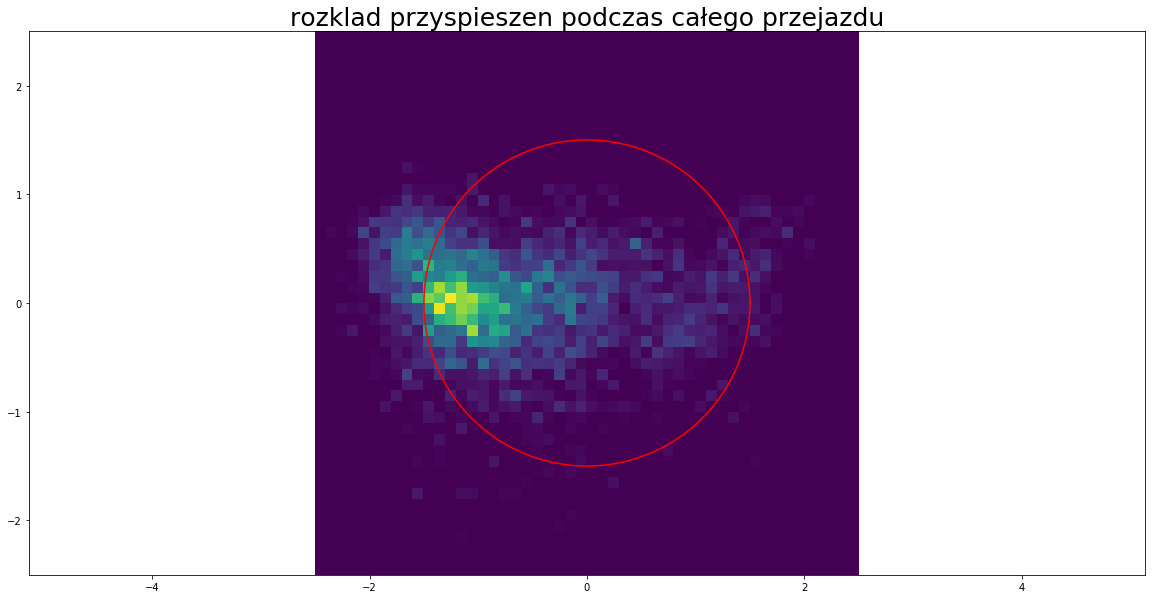

In [126]:
fig = plt.figure(figsize=(20,10))
plt.hist2d(y_acc_, x_acc_, bins=50, range=[[-2.5, 2.5], [-2.5, 2.5]])
plt.plot(1.5*np.cos(an), 1.5*np.sin(an), 'r')
plt.axis('equal')
plt.title('rozklad przyspieszen podczas całego przejazdu', fontsize=25)

# Przebiegi czasowe dla dwóch zakręców

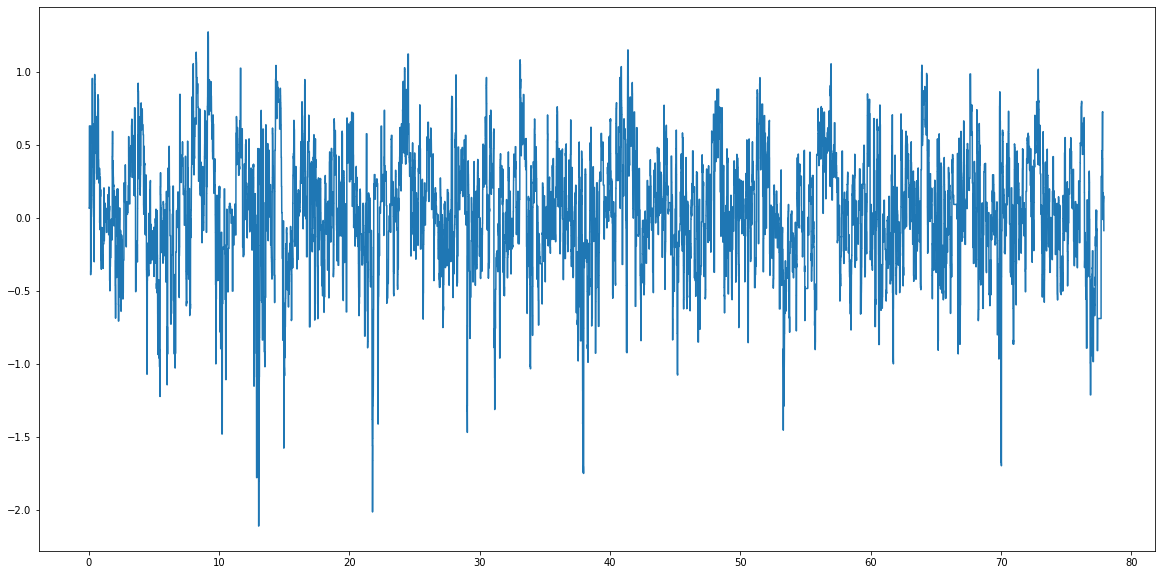

In [117]:
fig = plt.figure(figsize=(20,10))
plt.plot(time_, x_acc_)

In [118]:
first_time = data_mpc['rostime'][0]
data_mpc['time'] = [t-first_time for t in data_mpc['rostime']]

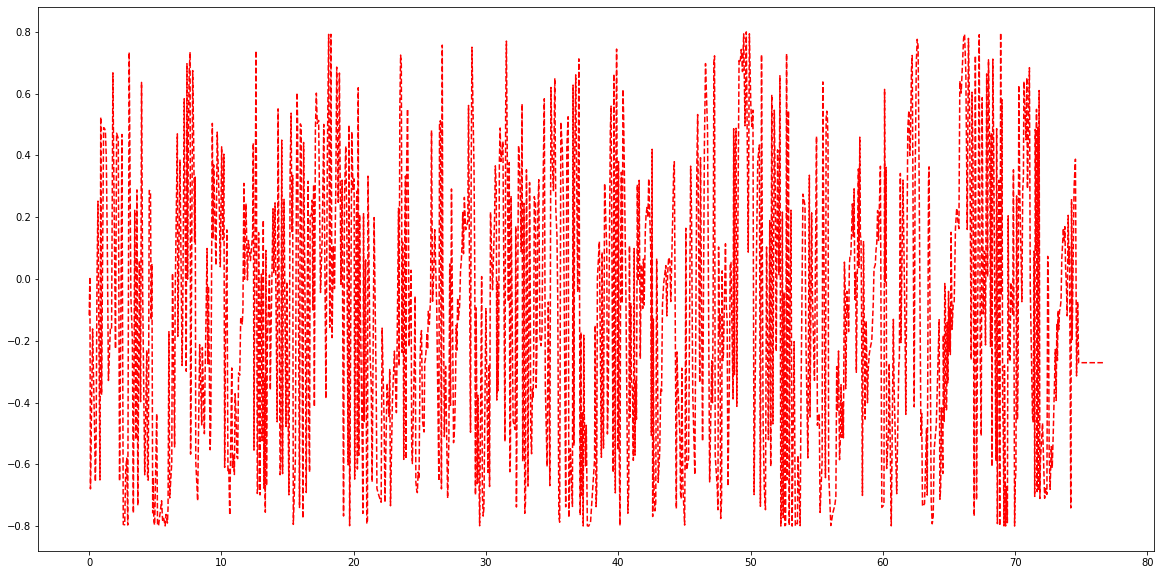

In [119]:
mpc_time = data_mpc['time']
mpc_x_acc = data_mpc['at']
mpc_y_acc = data_mpc['an']



fig = plt.figure(figsize=(20,10))
plt.plot(mpc_time, mpc_x_acc, '--r')

In [120]:
len(mpc_time)

969

# laps separately 

In [121]:
x_laps = np.split(x_pos, global_end_turn_indexes)
y_laps = np.split(y_pos, global_end_turn_indexes)

speed_laps = np.split(speed, global_end_turn_indexes)

ax_laps = np.split(x_acc_, global_end_turn_indexes)
ay_laps = np.split(y_acc_, global_end_turn_indexes)
az_laps = np.split(z_acc_, global_end_turn_indexes)

a_res_laps = [x**2 + y**2 for x,y in zip(ax_laps, ay_laps)]


# total acceleration

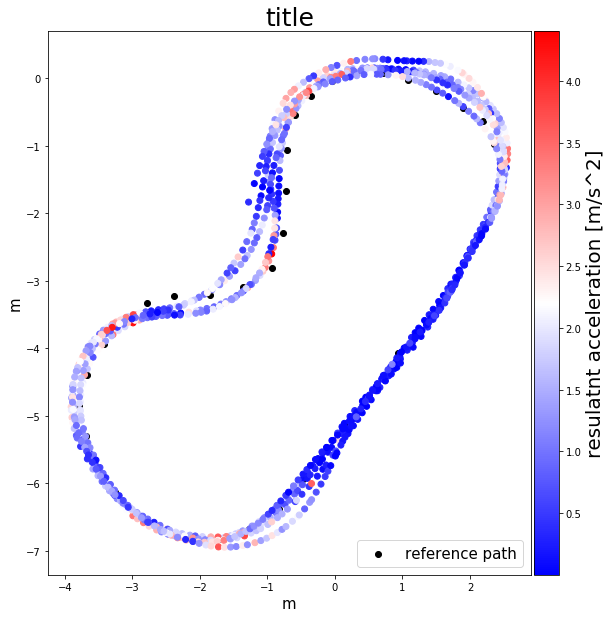

In [122]:
res_acc = [(x**2+y**2) for x,y in zip(avg_x_acc, avg_y_acc)]

fig = plt.figure(figsize=(20,10))
ax = plt.gca()
plt.title('title', fontsize=25)
plt.xlabel('m', fontsize=15)
plt.ylabel('m', fontsize=15)
plt.scatter(path_x, path_y, color='black')
plt.legend(['reference path'], loc='lower right', fontsize=15)
im = plt.scatter(x_avg, y_avg, c=res_acc, cmap='bwr')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cb = plt.colorbar(im, cax=cax)
cb.set_label('resulatnt acceleration [m/s^2]', fontsize=20)

ax.set_aspect('equal')


